In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
# clean and tranform data
df = pd.read_csv('LA_County_Covid19_cases.csv')
df = df[df['date'].notnull()]
df = df.fillna(0)
df['date'] = pd.to_datetime(df['date'])
df = df.astype({'new_case':'int32', 'new_deaths': 'int32', 'persons_tested': 'int32', 
            'persons_positive':'int32','hospitalizations':'int32'})
df.head()

,date,new_case,new_deaths,persons_tested,persons_positive,hospitalizations
0,2020-03-01,25,0,0,0,0
1,2020-03-02,19,0,0,0,0
2,2020-03-03,13,0,0,0,0
3,2020-03-04,19,0,0,0,0
4,2020-03-05,33,0,0,0,0


# Exploratory Data Analysis

In [3]:
# add new columns confirmed case and total death since 03/01/20
df['confirmed_case'] = df['new_case'].cumsum()
df['total_death'] = df['new_deaths'].cumsum()

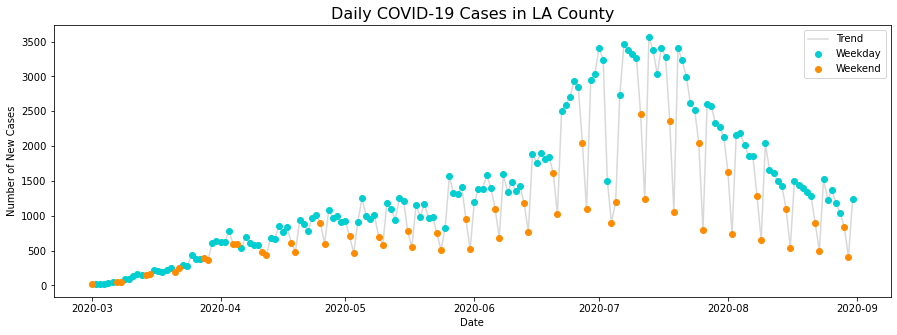

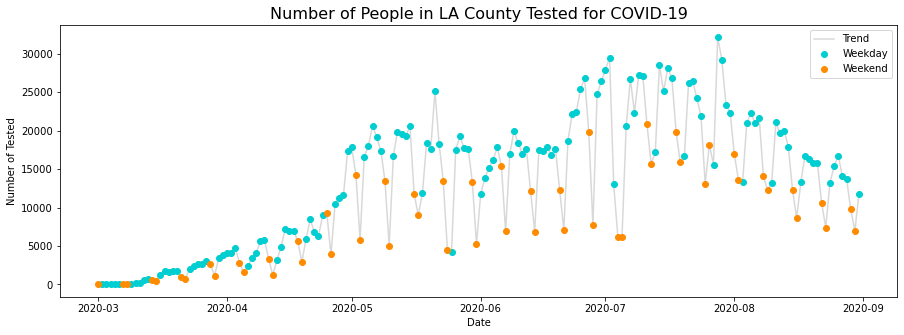

In [4]:

def EDA_plot(y, y_label,title):
    weekend = df['date'].dt.dayofweek >= 5
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    plt.plot('date',y,data=df,color='grey',alpha=0.3,label='Trend')
    plt.plot( 'date', y, data=df[-weekend],marker='o',linestyle = 'None',color='darkturquoise',label='Weekday')
    plt.plot('date',y,data=df[weekend],marker='o',linestyle = 'None',color='darkorange',label='Weekend')
    plt.ylabel(y_label)
    plt.xlabel('Date')
    plt.title(title,fontsize=16)
    plt.legend()
    plt.show()

EDA_plot('new_case',"Number of New Cases",'Daily COVID-19 Cases in LA County')
EDA_plot('persons_tested','Number of Tested','Number of People in LA County Tested for COVID-19')

# Forecast

In [5]:
#pip install fbprophet
import fbprophet
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from math import sqrt
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [6]:
# set last 14 days as test set, the rest as train set
# new case
split = df['date'] < '2020-08-18'
new_case_train = df[split][['date','new_case']]
new_case_train.columns = ['ds', 'y']
new_case_test = df[-split][['date','new_case']]
new_case_test.columns = ['ds', 'y']

# hyperparameters tuning 
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.05,0.1,0.15,0.175,0.2,0.25],
              'holidays_prior_scale':[0.2,0.25,0.3,0.35,0.4],
              'n_changepoints' : [50,75,100,125,150,200]
            }
grid = ParameterGrid(params_grid)

In [7]:
# return parameters with mae and rmse
def param(train_data,test_data,gird):
    model_parameters = pd.DataFrame(columns = ['MAE','RMSE','Parameters'])
    for p in grid:
        test = pd.DataFrame()
        train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                             holidays_prior_scale = p['holidays_prior_scale'],
                             n_changepoints = p['n_changepoints'],
                             seasonality_mode = p['seasonality_mode'],
                             weekly_seasonality=True,
                             interval_width=0.95)

        train_model.fit(train_data)
        train_forecast = train_model.make_future_dataframe(periods=14, freq='D',include_history = False)
        train_forecast = train_model.predict(train_forecast)
        pred=train_forecast[['ds','yhat']]
        Actual = test_data
        # calculate MAE, RMSE between expected and predicted values for december
        mae = mean_absolute_error(test_data['y'], pred['yhat'])
        rmse = sqrt(mean_squared_error(test_data['y'], pred['yhat']))
        model_parameters = model_parameters.append({'MAE':mae,'RMSE':rmse,'Parameters':p},ignore_index=True)
        
    parameters = model_parameters.sort_values(by=['RMSE'])
    parameters = parameters.reset_index(drop=True)  
    return parameters

In [8]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

parameters = param(new_case_train, new_case_test, grid)
parameters.head()

,MAE,RMSE,Parameters
0,104.382469,111.707344,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
1,104.382469,111.707344,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
2,104.382469,111.707344,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
3,104.382469,111.707344,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
4,104.382469,111.707344,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."


In [9]:
# best parameters with MAE = 104 and RMSE = 111.7
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.15,
 'holidays_prior_scale': 0.4,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

In [10]:
final_model = Prophet(
                      changepoint_prior_scale= 0.15,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      interval_width=0.95)

final_model.fit(new_case_train)
future = final_model.make_future_dataframe(periods=14, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
179,2020-08-27,1218.115568,551.579858,1917.429143
180,2020-08-28,1091.591799,398.516926,1719.661993
181,2020-08-29,709.962501,64.156876,1378.398234
182,2020-08-30,291.817322,-361.446567,882.974034
183,2020-08-31,1100.791140,482.160551,1734.650729


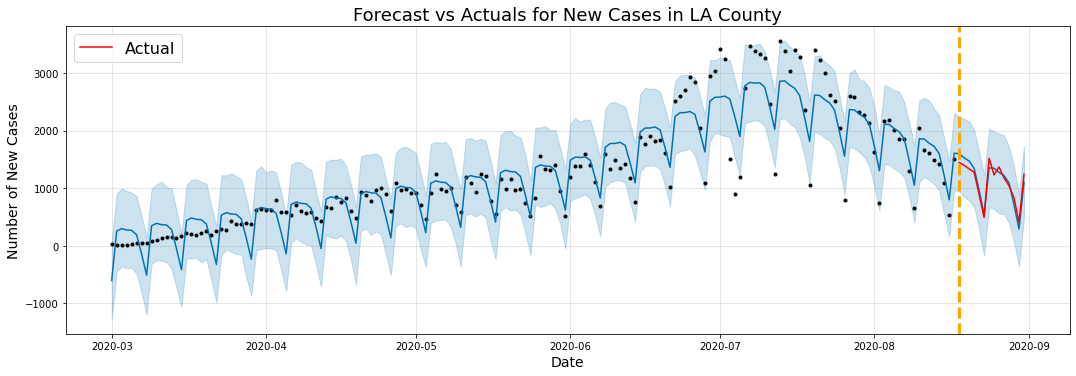

In [11]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.plot(new_case_test['ds'],new_case_test['y'],'r',label='Actual')
plt.axvline(x=datetime.datetime(2020, 8, 18), color='orange', linestyle='--',lw=3)
plt.title('Forecast vs Actuals for New Cases in LA County',fontsize = 18)
plt.ylabel("Number of New Cases",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=16)
plt.show()

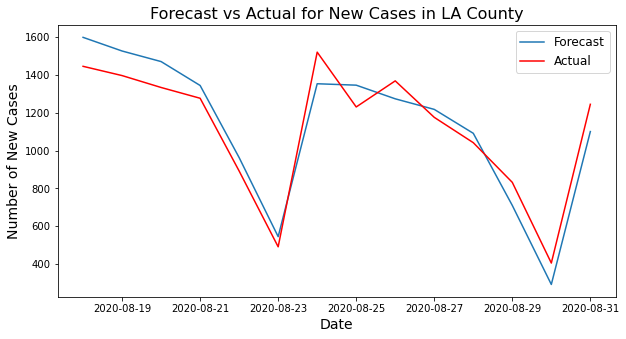

In [12]:
# during 08/18/20 - 08/31/20
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fct = forecast[['ds','yhat']][-14:]
plt.plot(fct['ds'],fct['yhat'],label='Forecast')
plt.plot(new_case_test['ds'],new_case_test['y'],'r',label='Actual')
plt.title('Forecast vs Actual for New Cases in LA County',fontsize=16)
plt.ylabel("Number of New Cases",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [13]:
# set last 14 days as test set, the rest as train set
# hospitalizations
split = df['date'] < '2020-08-18'
h_train = df[split][['date','hospitalizations']]
h_train.columns = ['ds', 'y']
h_test = df[-split][['date','hospitalizations']]
h_test.columns = ['ds', 'y']

# hyperparameters tuning 
params_grid_2 = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.05,0.1,0.15,0.175,0.2,0.25],
              'holidays_prior_scale':[0.2,0.25,0.3,0.35,0.4],
                'weekly_seasonality':(True,False),
              'n_changepoints' : [50,75,100,125,150,200]
            }
grid_2 = ParameterGrid(params_grid_2)

In [14]:
# MAE = 18 and RMSE = 22.6
parameters = param(h_train, h_test, grid_2)
parameters.head()

,MAE,RMSE,Parameters
0,17.909289,22.584922,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,17.909289,22.584922,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,17.909289,22.584922,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,17.909289,22.584922,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,17.909289,22.584922,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


In [15]:
# best parameters with MAE = 17.9 and RMSE= 22.6
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.3,
 'n_changepoints': 125,
 'seasonality_mode': 'multiplicative'}

In [16]:
final_model_2 = Prophet(
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 125,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      interval_width=0.95)

final_model_2.fit(h_train)
future_2 = final_model_2.make_future_dataframe(periods=14, freq='D')
forecast_2 = final_model_2.predict(future_2)
forecast_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
179,2020-08-27,1085.419246,924.062530,1239.704732
180,2020-08-28,1038.746415,865.567115,1207.151580
181,2020-08-29,1030.116953,856.826566,1217.335513
182,2020-08-30,1026.784448,840.523180,1209.865598
183,2020-08-31,1004.930239,810.392727,1216.002149


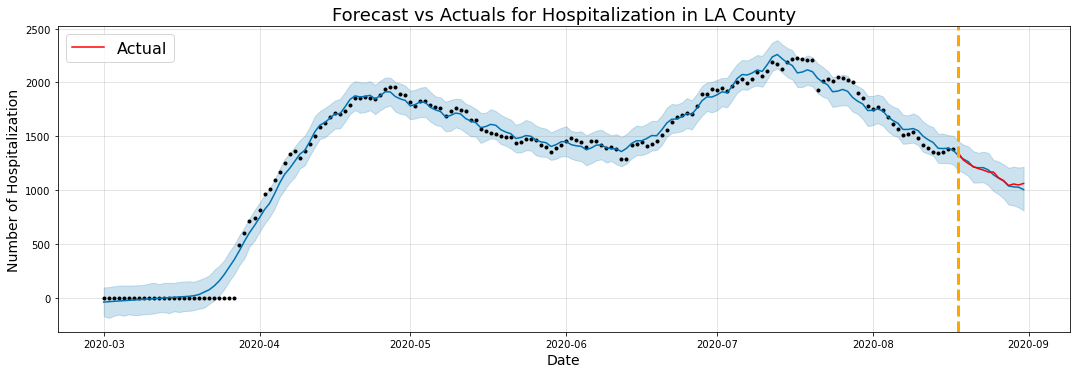

In [17]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model_2.plot(forecast_2,ax=ax)
plt.plot(h_test['ds'],h_test['y'],'r',label='Actual')
plt.axvline(x=datetime.datetime(2020, 8, 18), color='orange', linestyle='--',lw=3)
plt.title('Forecast vs Actuals for Hospitalization in LA County',fontsize=18)
plt.ylabel("Number of Hospitalization",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=16)
plt.show()

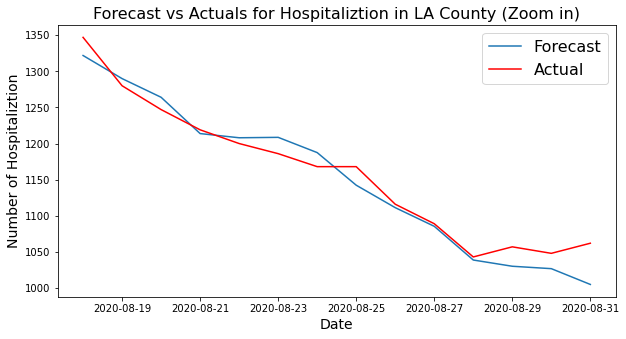

In [18]:
# I have actual data from 08/18/20 to 08/31/20
# validation set 
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fct_2 = forecast_2[['ds','yhat']][-14:]
plt.plot(fct_2['ds'],fct_2['yhat'],label='Forecast')
plt.plot(h_test['ds'],h_test['y'],'r',label='Actual')
plt.title('Forecast vs Actuals for Hospitaliztion in LA County (Zoom in)',fontsize=16)
plt.ylabel("Number of Hospitaliztion",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [19]:
# predicting hospitalization for the next two weeks
# we don't have actual data
model = Prophet(changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 125,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      interval_width=0.95)
input_data = df[['date','hospitalizations']]
input_data.columns = ['ds', 'y']
model.fit(input_data)
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
193,2020-09-10,685.664986,539.602299,830.926145
194,2020-09-11,645.466421,489.918193,809.023094
195,2020-09-12,629.001700,463.910138,812.158141
196,2020-09-13,615.129161,431.108247,790.901991
197,2020-09-14,590.475905,411.253799,782.629561


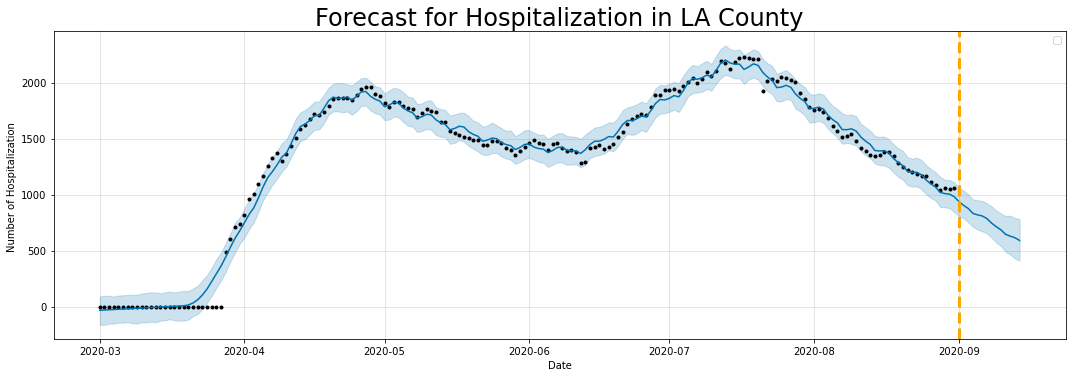

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.axvline(x=datetime.datetime(2020, 9, 1), color='orange', linestyle='--',lw=3)
plt.title('Forecast for Hospitalization in LA County',fontsize=24)
plt.ylabel("Number of Hospitalization ")
plt.xlabel('Date')
plt.legend()
plt.show()